In [10]:
from pathlib import Path

import eelbrain
from matplotlib import pyplot
import mne
import re
import trftools

In [11]:
# Data locations
DATA_ROOT = Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'
TRF_DIR = DATA_ROOT / 'TRFs'
#SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name)]
SUBJECTS =['S01']

In [5]:
# Where to save the figure
DST = DATA_ROOT / 'figures'
DST.mkdir(exist_ok=True)

In [4]:
# Configure the matplotlib figure style
FONT = 'Helvetica Neue'
FONT_SIZE = 8
RC = {
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.transparent': True,
    # Font
    'font.family': 'sans-serif',
    'font.sans-serif': FONT,
    'font.size': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
}
pyplot.rcParams.update(RC)

## A) Envelope

In [2]:
import os

from scipy.io import loadmat
import mne
from eelbrain import *

In [12]:
subject = 'S01'
trf1 = load.unpickle(TRF_DIR / subject / f'{subject} envelope.pickle')

In [3]:
filename='C:/Users/LG/Data/LittlePrince/TRFs/R0443/R0443 envelope.pickle'
trf2 = load.unpickle(filename)

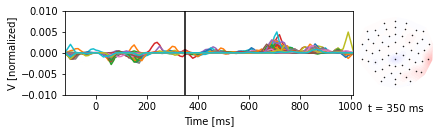

In [15]:
#Little Prince

%matplotlib inline
p = plot.TopoButterfly(trf2.h, w=6, h=2, vmax = 0.01)
#p = plot.TopoButterfly(trf.h_scaled, w=6, h=2)
p.set_time(.35)

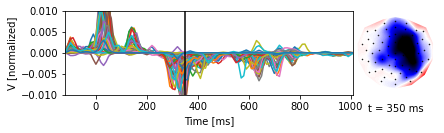

In [16]:
#Alice 

p = plot.TopoButterfly(trf1.h, w=6, h=2, vmax = 0.01)
p.set_time(.35)

<IPython.core.display.Javascript object>


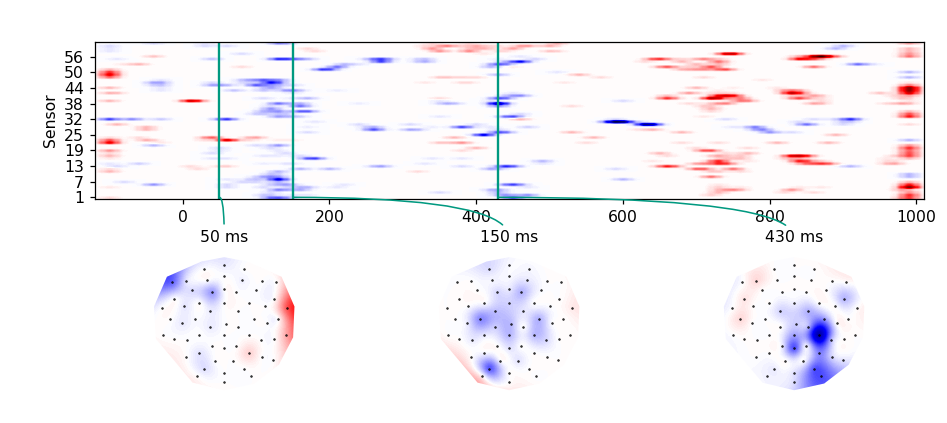

In [26]:
p = plot.TopoArray(trf2.h, w=6, h=2, t=(.050, .150, .430))

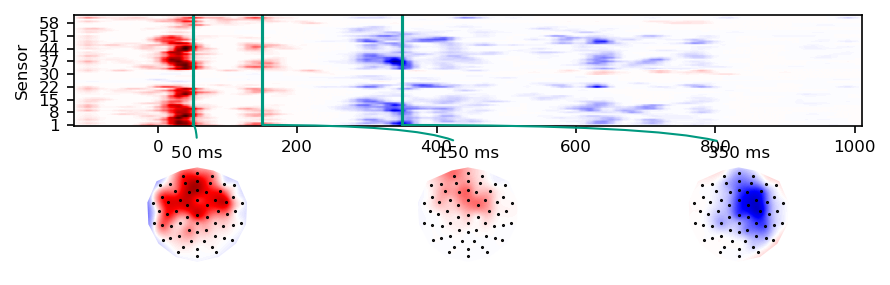

In [23]:
p = plot.TopoArray(trf1.h_scaled, w=6, h=2, t=(.050, .150, .350))

In [18]:
# Examine results from predicting EEG data from the speech envelope alone.

# Load predictive power and TRFs of the envelope models
rows = []
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} envelope.pickle')
    rows.append([subject, trf.proportion_explained, trf.h[0]])
data_envelope = eelbrain.Dataset.from_caselist(['subject', 'det', 'trf'], rows)

# test that model predictive power on held-out data is > 0
test_envelope = eelbrain.testnd.TTestOneSample('det', ds=data_envelope, tail=1, pmin=0.05)
p = eelbrain.plot.Topomap(test_envelope)
cb = p.plot_colorbar(width=0.1)

ValueError: Can not assign item to Dataset['det']. The item`s length 0 is different from the number of cases in the Dataset 3.

In [ ]:
# ## Envelope TRF
# Test the TRF with a one-sample *t*-test against 0. This tests the null-hypothesis that the electrical current direction at each time point was random across subjects. The systematic current directions shown below at anterior electrodes are typical of auditory responses. 

trf_envelope = eelbrain.testnd.TTestOneSample('trf', ds=data_envelope, pmin=0.05)

p = eelbrain.plot.TopoArray(trf_envelope, t=[0.040, 0.090, 0.140, 0.250, 0.400], clip='circle', cmap='xpolar')
cb = p.plot_colorbar(width=0.1)


## B Envelope + onset envelope

Test a second model which adds acoustic onsets (onsets are also represented as one-dimensional time-series, with onsets collapsed across frequency bands).


In [ ]:
# load cross-validated predictive power and TRFs of the spectrogram models
rows = []
x_names = None
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} envelope+onset.pickle')
    rows.append([subject, trf.proportion_explained, *trf.h])
    x_names = trf.x
data_onset = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rows)

# Compare predictive power of the two models
test_onset = eelbrain.testnd.TTestOneSample('det', ds=data_onset, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_onset_envelope = eelbrain.testnd.TTestRelated(data_onset['det'], data_envelope['det'], tail=1, pmin=0.05)
p = eelbrain.plot.Topomap(
    [test_onset.masked_difference(), test_onset_envelope.masked_difference()], 
    axtitle=[['Envelope + Onsets\n', test_onset], ['Envelope + Onsets > Envelope\n', test_onset_envelope]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)

trf_eo_envelope = eelbrain.testnd.TTestOneSample('envelope', ds=data_onset, pmin=0.05)
trf_eo_onset = eelbrain.testnd.TTestOneSample('onset', ds=data_onset, pmin=0.05)


## C) Full acoustic model

Load results form the full which included spectrogram as well as an onset spectrogram, both predictors represented as 2d time-series with 8 frequency bins each.


In [24]:
strf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} acoustic.pickle')

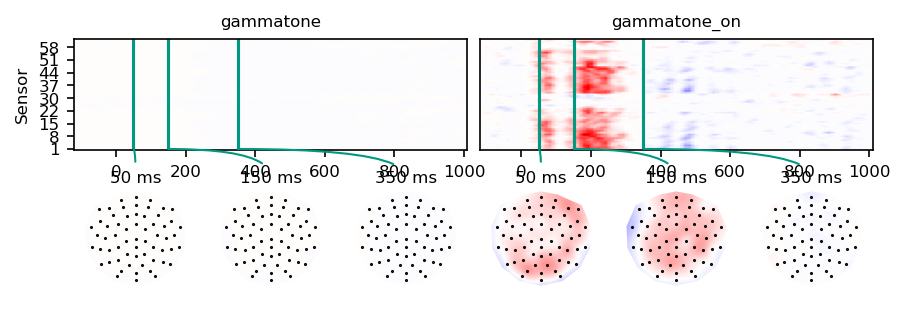

In [25]:
p = plot.TopoArray(strf.h_scaled, w=6, h=2, t=(.050, .150, .350))

In [26]:
auditory_sensors = ['59', '20', '21', '7', '8', '9', '49', '19' ,'44', '45', '34' ,'35' ,'36' ,'10']


In [28]:
strf_spectrogram = strf.mean(sensor=auditory_sensors).smooth('frequency', window_samples=7, fix_edges=True)


AttributeError: 'BoostingResult' object has no attribute 'mean'

In [31]:
# Load cross-validated preditive power of the full acoustic models
rows = []
x_names = None
for subject in SUBJECTS:
    trf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} acoustic.pickle')
    rows.append([subject, trf.proportion_explained, *trf.h])
    x_names = trf.x

In [36]:
rows

[['S01',
  <NDVar 'det': 61 sensor>,
  <NDVar 'gammatone': 61 sensor, 8 frequency, 114 time>,
  <NDVar 'gammatone_on': 61 sensor, 8 frequency, 114 time>]]

In [35]:
data_acoustic = eelbrain.Dataset.from_caselist(['subject', 'det', *x_names], rows)
print(x_names)

ValueError: Can not assign item to Dataset['det']. The item`s length 0 is different from the number of cases in the Dataset 3.

In [ ]:
# Compare predictive power of the two models
test_acoustic = eelbrain.testnd.TTestOneSample('det', ds=data_acoustic, tail=1, pmin=0.05)
# Paired t-test by specifying two measurement NDVars with matched cases
# Note that this presupposes that subjects are in the same order
test_acoustic_onset = eelbrain.testnd.TTestRelated(data_acoustic['det'], data_onset['det'], tail=1, pmin=0.05)
p = eelbrain.plot.Topomap(
    [test_acoustic.masked_difference(), test_acoustic_onset.masked_difference()], 
    axtitle=[[['Spectrogram\n', test_acoustic], ], ['Spectrogram > Envelope\n', test_acoustic_onset]],
    ncol=2, clip='circle')
cb = p.plot_colorbar(width=0.1)


In [ ]:
# ## TRFs
# Since these spectrogram mTRFs have a frequency dimension in addition to time and sensor we have to slice or aggregate them for visualization on a 2d plot. We take two approaches: 
#
#  1) Sum across the frequency, based on the assumtopn that TRFs are similar for different frequency bands
#  2) Average across a group of neighboring sensors, to verify this assumtopn 

trf_spectrogram = eelbrain.testnd.TTestOneSample("gammatone.sum('frequency')", ds=data_acoustic, pmin=0.05)
trf_onset_spectrogram = eelbrain.testnd.TTestOneSample("gammatone_on.sum('frequency')", ds=data_acoustic, pmin=0.05)

p = eelbrain.plot.TopoArray([trf_spectrogram, trf_onset_spectrogram], t=[0.050, 0.100, 0.150, 0.450], xlim=(-0.050, 0.950))

# Manually define sensors that are sensitive to acoustic responses 
auditory_sensors = ['59', '20', '21', '7', '8', '9', '49', '19' ,'44', '45', '34' ,'35' ,'36' ,'10']
p = eelbrain.plot.SensorMap(data_acoustic['det'], h=2, mark=auditory_sensors)

strf_spectrogram = data_acoustic['gammatone'].mean(sensor=auditory_sensors).smooth('frequency', window_samples=7, fix_edges=True)
strf_onset_spectrogram = data_acoustic['gammatone_on'].mean(sensor=auditory_sensors)
p = eelbrain.plot.Array([strf_spectrogram, strf_onset_spectrogram], ncol=2, xlim=(-0.050, 0.950))

# # Generate figure

# Load stimuli
gammatone = eelbrain.load.unpickle(DATA_ROOT / 'stimuli' / '1-gammatone.pickle').sub(time=(0, 3.001))
gammatone = (gammatone.clip(0) + 1).log()
gammatone_on = trftools.neural.edge_detector(gammatone, c=30)
gammatone /= gammatone.max()
gammatone_on /= gammatone_on.max()

# Load cross-validated preditive power of all models
models = ['envelope', 'envelope+onset', 'acoustic']
rows = []
for model in models:
    for subject in SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} {model}.pickle')
        rows.append([subject, model, trf.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
# For more interpretable numbers, express proportion explained in terms of the maximum explained variability by the full model
index = model_data['model'] == 'acoustic'
model_data['det'] *= 100 / model_data[index, 'det'].mean('case').max('sensor')
# Redo tests with adjusted predictive power 
test_envelope = eelbrain.testnd.TTestOneSample('det', sub="model == 'envelope'", ds=model_data, tail=1, pmin=0.05)
test_acoustic = eelbrain.testnd.TTestOneSample('det', sub="model == 'acoustic'", ds=model_data, tail=1, pmin=0.05)
test_onset_envelope = eelbrain.testnd.TTestRelated('det', 'model', 'envelope+onset', 'envelope', 'subject', ds=model_data, tail=1, pmin=0.05)
test_acoustic_onset = eelbrain.testnd.TTestRelated('det', 'model', 'acoustic', 'envelope+onset', 'subject', ds=model_data, tail=1, pmin=0.05)

# +
# Initialize figure
figure = pyplot.figure(figsize=(7.5, 8))
gridspec = figure.add_gridspec(10, 10, top=0.97, bottom=0.05, left=0.05, right=0.95, hspace=0.3, height_ratios=[2,2,2,2,2,2,2,2,1,2], width_ratios=[2,2,2,2,2,1,2,2,2,2])
topo_args = dict(clip='circle')
array_args = dict(xlim=(-0.050, 1.0), axtitle=False)
topo_array_args = dict(topo_labels='below', **array_args, **topo_args)
det_args = dict(**topo_args, vmax=100, cmap='lux-a')
cbar_args = dict(h=.5)
t_envelope = [0.050, 0.100, 0.150, 0.400]
t_onset = [0.060, 0.110, 0.180]

# A) Predictors
# -------------
axes = [
    figure.add_subplot(gridspec[0,0:3]),
    figure.add_subplot(gridspec[1,0:3]),
]
eelbrain.plot.Array([gammatone, gammatone_on], axes=axes, axtitle=False, xticklabels=-1, yticklabels=False)
# axes[0].set_ylabel('Gammatone\nSpectrogram', loc='bottom')
# axes[1].set_ylabel('Onset\nSpectrogram', loc='bottom')
for ax, y in zip(axes, (gammatone, gammatone_on)):
    y = y.sub(time=(1, None)).sum('frequency')
    y -= y.min()
    y *= 150 / y.max()
    y += 50
    ax.plot(y.time.times, y.x)

# B) Envelope
# -----------
# Predictive power tests
axes = figure.add_subplot(gridspec[1,4])
p = eelbrain.plot.Topomap(test_envelope.masked_difference(), axes=axes, **det_args)
axes.set_title("Envelope\npredictive power", loc='left')
p.plot_colorbar(below=axes, **cbar_args, ticks=3, label='%')
# TRF
axes = [
    figure.add_subplot(gridspec[0,7:10]), 
    figure.add_subplot(gridspec[1,6]),
    figure.add_subplot(gridspec[1,7]),
    figure.add_subplot(gridspec[1,8]), 
    figure.add_subplot(gridspec[1,9]),
]
p = eelbrain.plot.TopoArray(trf_envelope, t=t_envelope, axes=axes, **topo_array_args)
vmin, vmax = p.get_vlim()
axes[0].set_title('Envelope TRF', loc='left')
p.plot_colorbar(below=axes[1], **cbar_args, ticks=0, label='TRF (a.u.)')

# C) Envelope + onsets
# --------------------
# Predictive power tests
axes = figure.add_subplot(gridspec[4,0])
p = eelbrain.plot.Topomap(test_onset_envelope.masked_difference(), axes=axes, **det_args)
axes.set_title("Predictive Power\n> Envelope", loc='left')
# TRFs
axes = [
    figure.add_subplot(gridspec[3,2:5]), 
    figure.add_subplot(gridspec[4,2]), 
    figure.add_subplot(gridspec[4,3]),
    figure.add_subplot(gridspec[4,4]),
]
p = eelbrain.plot.TopoArray(trf_eo_onset, t=t_onset, axes=axes, vmin=vmin, vmax=vmax, **topo_array_args)
axes[0].set_title('Onset TRF', loc='left')
axes = [
    figure.add_subplot(gridspec[3,7:10]), 
    figure.add_subplot(gridspec[4,6]), 
    figure.add_subplot(gridspec[4,7]), 
    figure.add_subplot(gridspec[4,8]),
    figure.add_subplot(gridspec[4,9]), 
]
p = eelbrain.plot.TopoArray(trf_eo_envelope, t=t_envelope, axes=axes, **topo_array_args)
axes[0].set_title('Envelope TRF', loc='left')
y_b = axes[0].get_position().y1

# D) Spectrograms
# ---------------
# Predictive power tests
axes = figure.add_subplot(gridspec[7, 0])
p = eelbrain.plot.Topomap(test_acoustic_onset.masked_difference(), axes=axes, **det_args)
axes.set_title("Predictive Power\n> Envelope + Onsets", loc='left')
# TRFs
axes = [
    figure.add_subplot(gridspec[6,2:5]), 
    figure.add_subplot(gridspec[7,2]), 
    figure.add_subplot(gridspec[7,3]),
    figure.add_subplot(gridspec[7,4]),
]
p = eelbrain.plot.TopoArray(trf_onset_spectrogram, t=t_onset, axes=axes, **topo_array_args)
axes[0].set_title('Onset STRF (sum across frequency)', loc='left')
axes = [
    figure.add_subplot(gridspec[6,7:10]),
    figure.add_subplot(gridspec[7,6]), 
    figure.add_subplot(gridspec[7,7]),
    figure.add_subplot(gridspec[7,8]), 
    figure.add_subplot(gridspec[7,9]), 
]
p = eelbrain.plot.TopoArray(trf_spectrogram, t=t_envelope, axes=axes, **topo_array_args)
axes[0].set_title('Envelope STRF (sum across frequency)', loc='left')
y_c = axes[0].get_position().y1
# E) Channel selection
axes = figure.add_subplot(gridspec[9,0])
p = eelbrain.plot.Topomap(test_acoustic.difference, axes=axes, **det_args)
p.mark_sensors(auditory_sensors, s=2, c='green')
axes.set_title("Channels for STRF", loc='left')
# STRFs
axes = [
    figure.add_subplot(gridspec[9,2:5]),
    figure.add_subplot(gridspec[9,7:10]),
]
eelbrain.plot.Array([strf_onset_spectrogram, strf_spectrogram], axes=axes, **array_args)
axes[0].set_title("Onset STRF", loc='left')
axes[1].set_title("Spectrogram STRF", loc='left')
y_d = axes[0].get_position().y1

figure.text(0.01, 0.98, 'A) Predictors', size=10)
figure.text(0.40, 0.98, 'B) Envelope', size=10)
figure.text(0.01, y_b + 0.04, 'C) Envelope + onsets', size=10)
figure.text(0.01, y_c + 0.04, 'D) Spectrogram + onset spectrogram', size=10)
figure.text(0.01, y_d + 0.04, 'E) Spectrogram + onset spectrogram: spectro-temporal response functions (STRFs)', size=10)

# eelbrain.plot.figure_outline()
figure.savefig(DST / 'Auditory-TRFs.pdf')
figure.savefig(DST / 'Auditory-TRFs.png')
